# Benchmarking science modules

This simple benchmark works the following:
1. Load data using Spark in a DataFrame
2. Apply a science module, and create a new column in the DataFrame
3. Transfer this column to the driver (to force the creation)

To try to monitor the impact of a science module $t_{science}$, we minimise other operations (e.g. I/O) by caching data on the executors, and by subtracting the time to perform other operations:

$$
\begin{equation}
t_{science} = t_{total} - t_{dry}
\end{equation}
$$

where 
- $t_{dry}$ is the time to load the data (from the executor's memory), and transfer one column to the driver without applying a science module
- $t_{total}$ is the time to load the data (from the executor's memory), and transfer one column to the driver after applying a science module.

Note this is an "on-sky" performance, as for each module there are filters that decide which alert is really processed inside based on physics (as opposed to processing all alerts blindly). For example, the crossmatch with SIMBAD applies on all alerts, while only a small fraction of alerts satisfies the criteria to be processed by the microlensing module.

## Modules

In [14]:
import os
import time

import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import DoubleType, StringType

from fink_utils.spark.utils import concat_col
from fink_utils.data.utils import format_data_as_snana
from fink_utils.xmatch.simbad import return_list_of_eg_host

from fink_science import __version__
from fink_science import __file__ as fspath
from fink_science.random_forest_snia.processor import rfscore_sigmoid_full
from fink_science.xmatch.processor import cdsxmatch, crossmatch_other_catalog
# from fink_science.snn.processor import snn_ia
# from fink_science.microlensing.processor import mulens
from fink_science.asteroids.processor import roid_catcher
# from fink_science.nalerthist.processor import nalerthist
# from fink_science.kilonova.processor import knscore
# from fink_science.snad.processor import extract_features_snad
# from fink_science.image_classification.processor import labels_assignation

from tensorflow import keras
from pathlib import Path

from sklearn.preprocessing import robust_scale as rs

from astronet.metrics import WeightedLogLoss
from astronet.preprocess import generate_gp_all_objects
from astronet.preprocess import robust_scale
import tensorflow as tf

In [2]:
print('Fink Science version: {}'.format(__version__))

Fink Science version: 1.2.0


## Loading data

Let's load one night of data (200,000 alerts -- or 8.2 GB):

In [3]:
import os
memory = "8g"
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [4]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("benchmarks") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/10 11:43:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark.sparkContext.getConf().getAll()

[('spark.executor.id', 'driver'),
 ('spark.driver.host', 'tallamjr-macbookpro-m1'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '50843'),
 ('spark.driver.memory', '8g'),
 ('spark.app.startTime', '1654857796129'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.app.name', 'benchmarks'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1654857797810'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.sql.warehouse.dir',
  'file:/Users/tallamjr/github/tallamjr/origin/astronet/notebooks/spark-warehouse')]

In [6]:
df = spark.read.format('parquet').load('../data/ztf/small_bench.parquet')
total_alerts = df.count()
print('Number of alerts: ', total_alerts)

22/06/10 11:43:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of alerts:  20000


In [7]:
df = df.limit(500)

In [8]:
import psutil
nproc = psutil.cpu_count()
print('Benchmark will be done using {} CPUs'.format(nproc))

Benchmark will be done using 10 CPUs


In [9]:
# nproc = int([val[1] for val in spark.sparkContext.getConf().getAll() if val[0] == 'spark.cores.max'][0])
# print('Benchmark will be done using {} CPUs'.format(nproc))

## Caching data

Cache the data to the executor memory to reduce I/O perturbations -- Make sure you have enough memory!

In [10]:
# Retrieve time-series information
to_expand = [
    'jd', 'fid', 'magpsf', 'sigmapsf',
    'magnr', 'sigmagnr', 'magzpsci', 'isdiffpos'
]

# Append temp columns with historical + current measurements
prefix = 'c'
for colname in to_expand:
    df = concat_col(df, colname, prefix=prefix)
expanded = [prefix + i for i in to_expand]

# add xmatch
colnames = [df['objectId'], df['candidate.ra'], df['candidate.dec']]
df = df.withColumn('cdsxmatch_tmp', cdsxmatch(*colnames))

# add roid
args_roid = [
    'cjd', 'cmagpsf',
    'candidate.ndethist', 'candidate.sgscore1',
    'candidate.ssdistnr', 'candidate.distpsnr1']
df = df.withColumn('roid_tmp', roid_catcher(*args_roid))

In [31]:
# Cache to reduce I/O perturbations
# Make sure you have enough memory
df = df.cache()
total_alerts = df.count()
print(total_alerts)

22/06/10 11:52:35 WARN CacheManager: Asked to cache already cached data.


500


## Calibration

Computation of $t_{dry}$

In [32]:
def zero_point(df, verbose=False):
    """ Execution time (s) to return one column to the driver with no science module
    """
    t0 = time.time()
    pdf = df.select('candidate.ra').toPandas()
    calib = time.time() - t0
    if verbose:
        print('Calibration time: ', calib)
        print('{} alert/s/proc'.format(total_alerts/calib/nproc))
    return calib, None, "DRY"

# zero_point(df, True)

## Science modules

### Solar System

In [33]:
def sso(df, verbose=False):
    t0 = time.time()
    args_roid = [
        'cjd', 'cmagpsf',
        'candidate.ndethist', 'candidate.sgscore1',
        'candidate.ssdistnr', 'candidate.distpsnr1']
    pdf = df.withColumn('roid', roid_catcher(*args_roid)).select('roid').toPandas()
    t_roid = time.time() - t0
    if verbose:
        print('roid time: ', t_roid)
        print('{} alert/s/proc'.format(total_alerts/t_roid/nproc))
    return t_roid, args_roid, "SSO"

# sso(df, True)

### T2

In [34]:
def apply_selection_cuts_ztf(
        magpsf: pd.Series, cdsxmatch: pd.Series,
        jd: pd.Series, jdstarthist: pd.Series, roid: pd.Series,
        minpoints: int = 2, maxndethist: int = 90) -> pd.Series:
    """ Apply selection cuts to keep only alerts of interest
    for T2 analysis

    Parameters
    ----------
    magpsf: pd.Series
        Series containing data measurement (array of double). Each row contains
        all measurement values for one alert.
    cdsxmatch: pd.Series
        Series containing crossmatch label with SIMBAD (str).
        Each row contains one label.
    jd: pd.Series
        Series containing JD values (array of float). Each row contains
        all measurement values for one alert.
    jdstarthist: pd.Series
        Series containing first JD for which the source varied (float).
        Each row contains one label.
    roid: pd.Series
        Series containing SSO label (int).
        Each row contains one label.

    Returns
    ---------
    mask: pd.Series
        Series containing `True` if the alert is valid, `False` otherwise.
        Each row contains one boolean.
    """
    # Flag empty alerts
    mask = magpsf.apply(lambda x: np.sum(np.array(x) == np.array(x))) >= minpoints

    mask *= jd.apply(lambda x: float(x[-1])) - jdstarthist.astype(float) <= maxndethist

    mask *= roid.astype(int) != 3

    list_of_sn_host = return_list_of_eg_host()
    mask *= cdsxmatch.apply(lambda x: x in list_of_sn_host)
    
    # Add cuts on having exactly 2 filters

    return mask

class LiteModel:
    @classmethod
    def from_file(cls, model_path):
        return LiteModel(tf.lite.Interpreter(model_path=model_path))

    @classmethod
    def from_saved_model(cls, model_path, tflite_file_path=None):
        converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
            tf.lite.OpsSet.SELECT_TF_OPS,  # enable TensorFlow ops.
        ]
        converter.experimental_enable_resource_variables = True
        converter.experimental_new_converter = True
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()

        if tflite_file_path is not None:
            with open(tflite_file_path, "wb") as f:
                f.write(tflite_model)

        return LiteModel(tf.lite.Interpreter(model_content=tflite_model))

    def __init__(self, interpreter):
        self.interpreter = interpreter
        self.interpreter.allocate_tensors()
        input_det = self.interpreter.get_input_details()[0]
        output_det = self.interpreter.get_output_details()[0]
        self.input_index = input_det["index"]
        self.output_index = output_det["index"]
        self.input_shape = input_det["shape"]
        self.output_shape = output_det["shape"]
        self.input_dtype = input_det["dtype"]
        self.output_dtype = output_det["dtype"]

    def predict(self, inp):
        inp = inp.astype(self.input_dtype)
        count = inp.shape[0]
        out = np.zeros((count, self.output_shape[1]), dtype=self.output_dtype)
        for i in range(count):
            self.interpreter.set_tensor(self.input_index, inp[i : i + 1])
            self.interpreter.invoke()
            out[i] = self.interpreter.get_tensor(self.output_index)[0]
        return out

def get_model(model_name):
    model_path = f"../astronet/tinho/models/plasticc/{model_name}"
    model = LiteModel.from_file(model_path=model_path)
    return model

@pandas_udf(StringType(), PandasUDFType.SCALAR)
def t2_spark(candid, jd, fid, magpsf, sigmapsf, roid, cdsxmatch, jdstarthist, model_name=None) -> pd.Series:
    """ Return max prob from T2

    Parameters
    ----------
    candid: Spark DataFrame Column
        Candidate IDs (int64)
    jd: Spark DataFrame Column
        JD times (float)
    fid: Spark DataFrame Column
        Filter IDs (int)
    magpsf, sigmapsf: Spark DataFrame Columns
        Magnitude from PSF-fit photometry, and 1-sigma error
    model_name: Spark DataFrame Column, optional
        T2 pre-trained model. Currently available:
            * t2 (default)
            * atx

    Returns
    ----------
    probabilities: 1D np.array of float
        Probability between 0 (non-Ia) and 1 (Ia).
    """
    mask = apply_selection_cuts_ztf(magpsf, cdsxmatch, jd, jdstarthist, roid)

    if len(jd[mask]) == 0:
        return pd.Series(np.array(['None'] * len(jd), dtype=np.str))
    
    ZTF_FILTER_MAP = {1: "ztfg", 2: "ztfr", 3: "ztfi"}

    ZTF_PB_WAVELENGTHS = {
        "ztfg": 4804.79,
        "ztfr": 6436.92,
        "ztfi": 7968.22,
    }
    
    # Rescale dates to _start_ at 0
    dates = jd.apply(lambda x: [x[0] - i for i in x])    

    pdf = format_data_as_snana(
        dates, magpsf, sigmapsf, fid, candid, mask, 
        filter_conversion_dic=ZTF_FILTER_MAP
    )
    
    # SNID, MJD, FLUXCAL, FLUXCALERR, FLT
    # ["object_id", "mjd", "flux", "flux_error", "filter"]
    pdf = pdf.rename(
        columns={
            'SNID': 'object_id', 
            'MJD': 'mjd', 
            'FLUXCAL': 'flux',
            'FLUXCALERR': 'flux_error',
            'FLT': 'filter'
        }
    )
    
    pdf = pdf.dropna()
    pdf = pdf.reset_index()

    if model_name is not None:
        # take the first element of the Series
        model = get_model(model_name=model_name.values[0])
    else:
        # Load default pre-trained model
        model = get_model()

    vals = []
    for candid_ in candid[mask].values:
        
        # one object at a time
        sub = pdf[pdf['object_id'] == candid_]
        
        # Need all filters
        if len(np.unique(sub['filter'])) != 2:
            vals.append('None')
            continue
        
        # one object at a time
        df_gp_mean = generate_gp_all_objects(
            [candid_], sub, pb_wavelengths=ZTF_PB_WAVELENGTHS
        )

        cols = set(list(ZTF_PB_WAVELENGTHS.keys())) & set(df_gp_mean.columns)
        # robust_scale(df_gp_mean, cols)
        X = df_gp_mean[cols]
        X = rs(X)
        X = np.asarray(X).astype("float32")
        X = np.expand_dims(X, axis=0)

        y_preds = model.predict(X)

        class_names = [
            "mu-Lens-Single",
            "TDE",
            "EB",
            "SNII",
            "SNIax",
            "Mira",
            "SNIbc",
            "KN",
            "M-dwarf",
            "SNIa-91bg",
            "AGN",
            "SNIa",
            "RRL",
            "SLSN-I",
        ]

        keys = class_names
        values = y_preds.tolist()
        predictions = dict(zip(keys, values[0]))

        #snia_val = predictions['SNIa']
        idx = np.where(np.array(list(predictions.values())) == np.max(list(predictions.values())))[0][0]
        snia_val = list(predictions.keys())[idx]
        vals.append(str(snia_val))

    to_return = np.array(['None'] * len(jd), dtype=np.str)
    to_return[mask] = vals

    # return class with max prob
    return pd.Series(to_return)


/opt/homebrew/Cellar/apache-spark/3.2.1/libexec/python/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [35]:
def t2(df, verbose=False):
    t0 = time.time()

    args = ['candid', 'cjd', 'cfid', 'cmagpsf', 'csigmapsf']
    args += [F.col('roid'), F.col('cdsxmatch'), F.col('candidate.jdstarthist')]
    args += [F.lit('quantized-model-GR-noZ-28341-1654269564-0.5.1.dev73+g70f85f8-LL0.836.tflite')]

    pdf2 = df.withColumn('pIa_t2', t2_spark(*args)).select('pIa_t2').toPandas()
    t_t2 = time.time() - t0
    if verbose:
        print('T2 time: ', t_t2)
        print('{} alert/s/proc'.format(total_alerts/t_t2/nproc))
    return t_t2, args, "T2"

# t2(df, True)

## Total

In [36]:
def total(df, args, verbose=False):
    """ keep the args order!
    """
    t0 = time.time()
    pdf = df.withColumn('roid', roid_catcher(*(args[0])))\
        .withColumn('pIa_t2', t2_spark(*args[1]))\
        .select(['roid', 'pIa_t2'])\
        .toPandas()
    t_all_modules = time.time() - t0
    if verbose:
        print('All modules time: ', t_all_modules)
        print('{} alert/s/proc'.format(total_alerts/t_all_modules/nproc))
    return t_all_modules

## Benchmark

In [37]:
zero_point(df)

(0.10967397689819336, None, 'DRY')

In [38]:
NLOOPS = 10

modules = [zero_point, sso, t2]
# modules = [zero_point, sso, snn, t2, al, mul, xmatch, kn, snad]
ts = []
for i in range(NLOOPS):
    print("Loop {}/{}".format(i+1, NLOOPS))
    names = []
    args_ = []
    times_ = []
    for mod in modules:
        t, args, name = mod(df)
        times_.append(t)
        if args is not None:
            args_.append(args)
            names.append(name)
    # Run all modules
    t_tot = total(df, args_)
    times_.append(t_tot)
    names.append('All')
    
    ts.append(times_)

Loop 1/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 2/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 3/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 4/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 5/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 6/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 7/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 8/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 9/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loop 10/10


/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/xh/xnl30qr16k5fldpn_ss_v0cm0000gn/T/ipykernel_32920/1693900588.py:214: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Mean and std for the execution times:

In [39]:
print(np.mean(ts, axis=0))
print(np.std(ts, axis=0))

[0.11 0.18 0.48 0.54]
[0.05 0.10 0.81 0.93]


## Final plot

In [40]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

First, change units from  execution time (second) to single core performance (number of alerts/second/core processed):

In [46]:
# ts
for j in ts:
    for i in j[1:]:
        print(i, j[0])

0.41593480110168457 0.08819103240966797
2.900285005569458 0.08819103240966797
3.3208301067352295 0.08819103240966797
0.1075291633605957 0.1121680736541748
0.14510393142700195 0.1121680736541748
0.1515810489654541 0.1121680736541748
0.10872602462768555 0.06022024154663086
0.19435811042785645 0.06022024154663086
0.40663886070251465 0.06022024154663086
0.2571859359741211 0.17185568809509277
0.36506009101867676 0.17185568809509277
0.1753091812133789 0.17185568809509277
0.1121211051940918 0.051969051361083984
0.16316986083984375 0.051969051361083984
0.2133948802947998 0.051969051361083984
0.2734971046447754 0.15379786491394043
0.3103902339935303 0.15379786491394043
0.27521395683288574 0.15379786491394043
0.08564901351928711 0.04935002326965332
0.130601167678833 0.04935002326965332
0.4272572994232178 0.04935002326965332
0.14790010452270508 0.20042681694030762
0.19705510139465332 0.20042681694030762
0.15347671508789062 0.20042681694030762
0.08605432510375977 0.055193185806274414
0.13280415534

In [49]:
ts_ = [[total_alerts/(i - j[0])/nproc for i in j[1:]] for j in ts]
# print(ts_)

mean = np.mean(ts_, axis=0)
err = np.std(ts_, axis=0)
print(mean, err)

[-527.65 -1011.77 1755.55] [3482.88 4621.09 4288.93]


Plot:

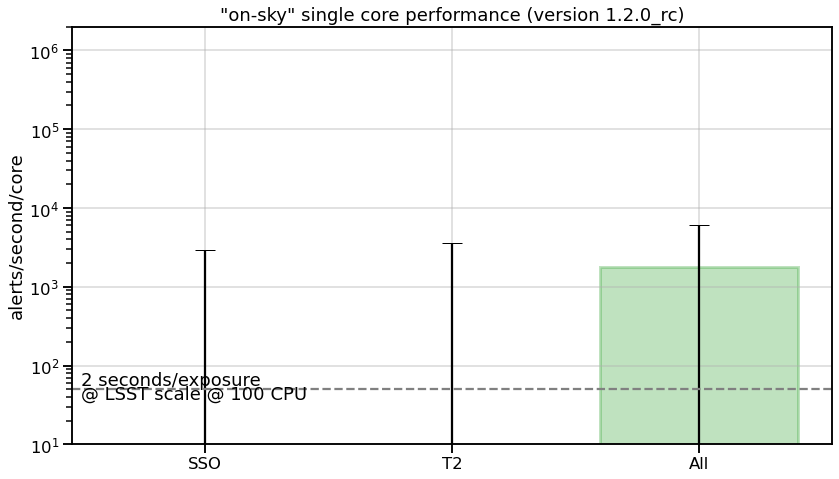

In [50]:
# names = ['SSO', 'SNN', 'T2', 'AL', 'ML', 'CDS', 'KN', 'FEAT', 'All']
names = ['SSO', 'T2','All']
plt.figure(figsize=(12, 7))

colors = ['C{}'.format(i) for i in range(len(names))]
plt.bar(
    names, mean, yerr=err, 
    color=colors, edgecolor=colors, ecolor='black', 
    linewidth=3, error_kw={'capsize': 10}, 
    alpha=0.3, fill=True
)
plt.grid(alpha=0.5)

# for index, ts__ in zip(range(len(mean)), mean):
#     plt.text(index - 0.15, 1.25 * ts__, int(ts__))

plt.ylabel('alerts/second/core')

plt.title('"on-sky" single core performance (version {})'.format('1.2.0_rc'))

plt.axhline(50, ls='--', color='grey')
plt.yscale('log')
plt.text(-0.5, 55, r'2 seconds/exposure');
plt.text(-0.5, 37, r'@ LSST scale @ 100 CPU');

plt.ylim(10, 2e6)
plt.tight_layout()
plt.show()

In [39]:
# naive total throughput
# total_throughput = 1/np.sum(1/np.array(mean))
# print('{:.2f} alerts/s/proc'.format(total_throughput))

In [73]:
total_throughput = mean[-1]
nalert_total = int(10e6)
nproc_total = 150
time_for_all = nalert_total / total_throughput / nproc_total
print('{:,} alerts: {:.2f} hours with {} cores'.format(nalert_total, time_for_all / 3600, nproc_total))

10,000,000 alerts: 0.00 hours with 150 cores
